# Análisis del dataset: Longitud de texto, cantidad de caracteres, duración de audios promedio


In [1]:
import pandas as pd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, kruskal, spearmanr
import seaborn as sns
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# for plotting
# set dpi to 300
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.autolayout"] = True
plot_dir = "../write-up/figuras/"


In [2]:
#Visualize the data
subjective_results = pd.read_csv('subjective_results_corrected.csv')
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,E/E2/arf_00610_00913913795.wav,5.0,E2,Open_ar_f_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,E/E2/arf_00610_00546762557.wav,5.0,E2,Open_ar_f_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,E/E2/arf_00610_00621699750.wav,5.0,E2,Open_ar_f_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,E/E2/arf_00610_00912390302.wav,4.0,E2,Open_ar_f_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,E/E2/arf_00610_01772510223.wav,4.0,E2,Open_ar_f_2,F,ARG,3.404321,NISQA_TTS_v1


In [3]:
# get stimuli column
stimuli = subjective_results['stimuli']

train_set = pd.read_csv('../classifier/train.csv')
stimuli = train_set['stimuli']

audio_lengths = []
for audio_path in stimuli:
    # extract the length of the audio file
    audio, sr = sf.read(audio_path)
    audio_lengths.append(len(audio)/sr)

# mean and standard deviation of audio lengths
mean_audio_length = np.mean(audio_lengths)
std_audio_length = np.std(audio_lengths)

print('Amount of audios rated: ', len(audio_lengths))
print('Mean audio length:', mean_audio_length)
print('Standard deviation of audio length:', std_audio_length)
print('Minimum audio length:', np.min(audio_lengths))
print('Maximum audio length:', np.max(audio_lengths))

print("Total audio length:", np.sum(audio_lengths)/60, "minutes")

Amount of audios rated:  3136
Mean audio length: 3.5314605189732147
Standard deviation of audio length: 1.6186195711413796
Minimum audio length: 0.92875
Maximum audio length: 13.497
Total audio length: 184.5776697916667 minutes


In [15]:
# print the spoken phrases in the audios
script = pd.read_csv('script.csv')
script.head()

,transcript
0,"Para la caída del cabello, tengo un nuevo jabón"
1,¿Qué color favorito es el más popular?
2,El pijama de rayas es azul
3,Las máquinas de escribir antiguas pueden ser m...
4,Al circular menos automóviles en la ciudad se ...


In [16]:
# Calculate word count for each phrase
script['word_count'] = script['transcript'].apply(lambda x: len(x.split()))

# Calculate character count for each phrase
script['char_count'] = script['transcript'].apply(lambda x: len(x))

# Calculate statistics
average_word_count = script['word_count'].mean()
average_char_count = script['char_count'].mean()
std_dev_word_count = script['word_count'].std()
std_dev_char_count = script['char_count'].std()
max_word_count = script['word_count'].max()
min_word_count = script['word_count'].min()
max_char_count = script['char_count'].max()
min_char_count = script['char_count'].min()
total_phrases = len(script)

# Output results
print("Average word count:", average_word_count)
print("Average character count:", average_char_count)
print("Standard deviation of word count:", std_dev_word_count)
print("Standard deviation of character count:", std_dev_char_count)
print("Maximum word count:", max_word_count)
print("Minimum word count:", min_word_count)
print("Maximum character count:", max_char_count)
print("Minimum character count:", min_char_count)
print("Total phrases:", total_phrases)

Average word count: 9.27
Average character count: 51.85
Standard deviation of word count: 4.019786918318789
Standard deviation of character count: 22.19763159629532
Maximum word count: 20
Minimum word count: 3
Maximum character count: 112
Minimum character count: 16
Total phrases: 100


## Descripción de los estimulos:

In [17]:
# gender_stiumuli distribution, grouped by stimuli_service
gender_stimuli_distribution = subjective_results.groupby(["stimuli_service", "gender_stimuli"])["stimuli"].count()

# count amount of F and M in gender_stimuli_distribution
gender_stimuli_count = gender_stimuli_distribution.groupby('gender_stimuli').size()
print(gender_stimuli_count)


gender_stimuli
F    26
M    26
Name: stimuli, dtype: int64


In [18]:
# dialects distribution, just count unique stimuli_service

dialects_distribution = subjective_results.groupby("stimuli_service")["dialect"].first().value_counts()
print(dialects_distribution)

dialect
ARG      22
ES        9
ES-US     7
CAST      5
MEX       5
BO        3
-         1
Name: count, dtype: int64


# Descripción del dataset: Resultados de la encuesta subjetiva

4327 pares de audios únicos, acompañados por una calificación de naturalidad del habla, en una escala tipo likert del 1 al 5.
+ Los audios provienen de ~50 sistemas distintos, en su gran mayoría, sistemas de TTS.
+ Los sistemas tienen distintos dialectos y generos de hablante
+ Los participantes, completaron una encuesta sociodemográfica, que incluye información sobre su edad, género, nivel de familiaridad con las voces sintetizadas, país/provincia de residencia, idioma nativo, y si tienen alguna discapacidad auditiva.
+ Cada participante evaluó, en promedio, 40 audios, cada uno de un sistema distinto.

# Análisis exploratorio de datos:

Se comienza cargando los datos, las columnas se corresponden con las distintas variables que se mencionaron en la descripción del dataset.

+ **participant_id**: identificador del participante
+ **age**: edad del participante
+ **gender_participant**: género del participante
+ **country**: país de residencia del participante
+ **province**: provincia de residencia del participante
+ **education**: nivel de familiaridad con voces sintetizadas del participante
+ **headphone_brand**: marca de auriculares utilizada por el participante
+ **stimuli**: identificador del audio
+ **score**: calificación de naturalidad del habla
+ **stimuli_group**: sistema utilizado para generar el audio (nombre corto)
+ **stimuli_service**: sistema utilizado para generar el audio (nombre largo)
+ **dialect**: dialecto de voz del estimulo
+ **mos_pred**: predicción de la naturalidad del audio realizada por NISQA_TTS_v1

In [4]:
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,E/E2/arf_00610_00913913795.wav,5.0,E2,Open_ar_f_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,E/E2/arf_00610_00546762557.wav,5.0,E2,Open_ar_f_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,E/E2/arf_00610_00621699750.wav,5.0,E2,Open_ar_f_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,E/E2/arf_00610_00912390302.wav,4.0,E2,Open_ar_f_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,E/E2/arf_00610_01772510223.wav,4.0,E2,Open_ar_f_2,F,ARG,3.404321,NISQA_TTS_v1


### Se calculan la distribución de los datos sociodemograficos de los participantes:

In [5]:
# compute the amount of unique participant_id in the participant_id column
unique_participant_id = subjective_results['participant_id'].nunique()
print('The amount of unique participant_id is:', unique_participant_id)

The amount of unique participant_id is: 92


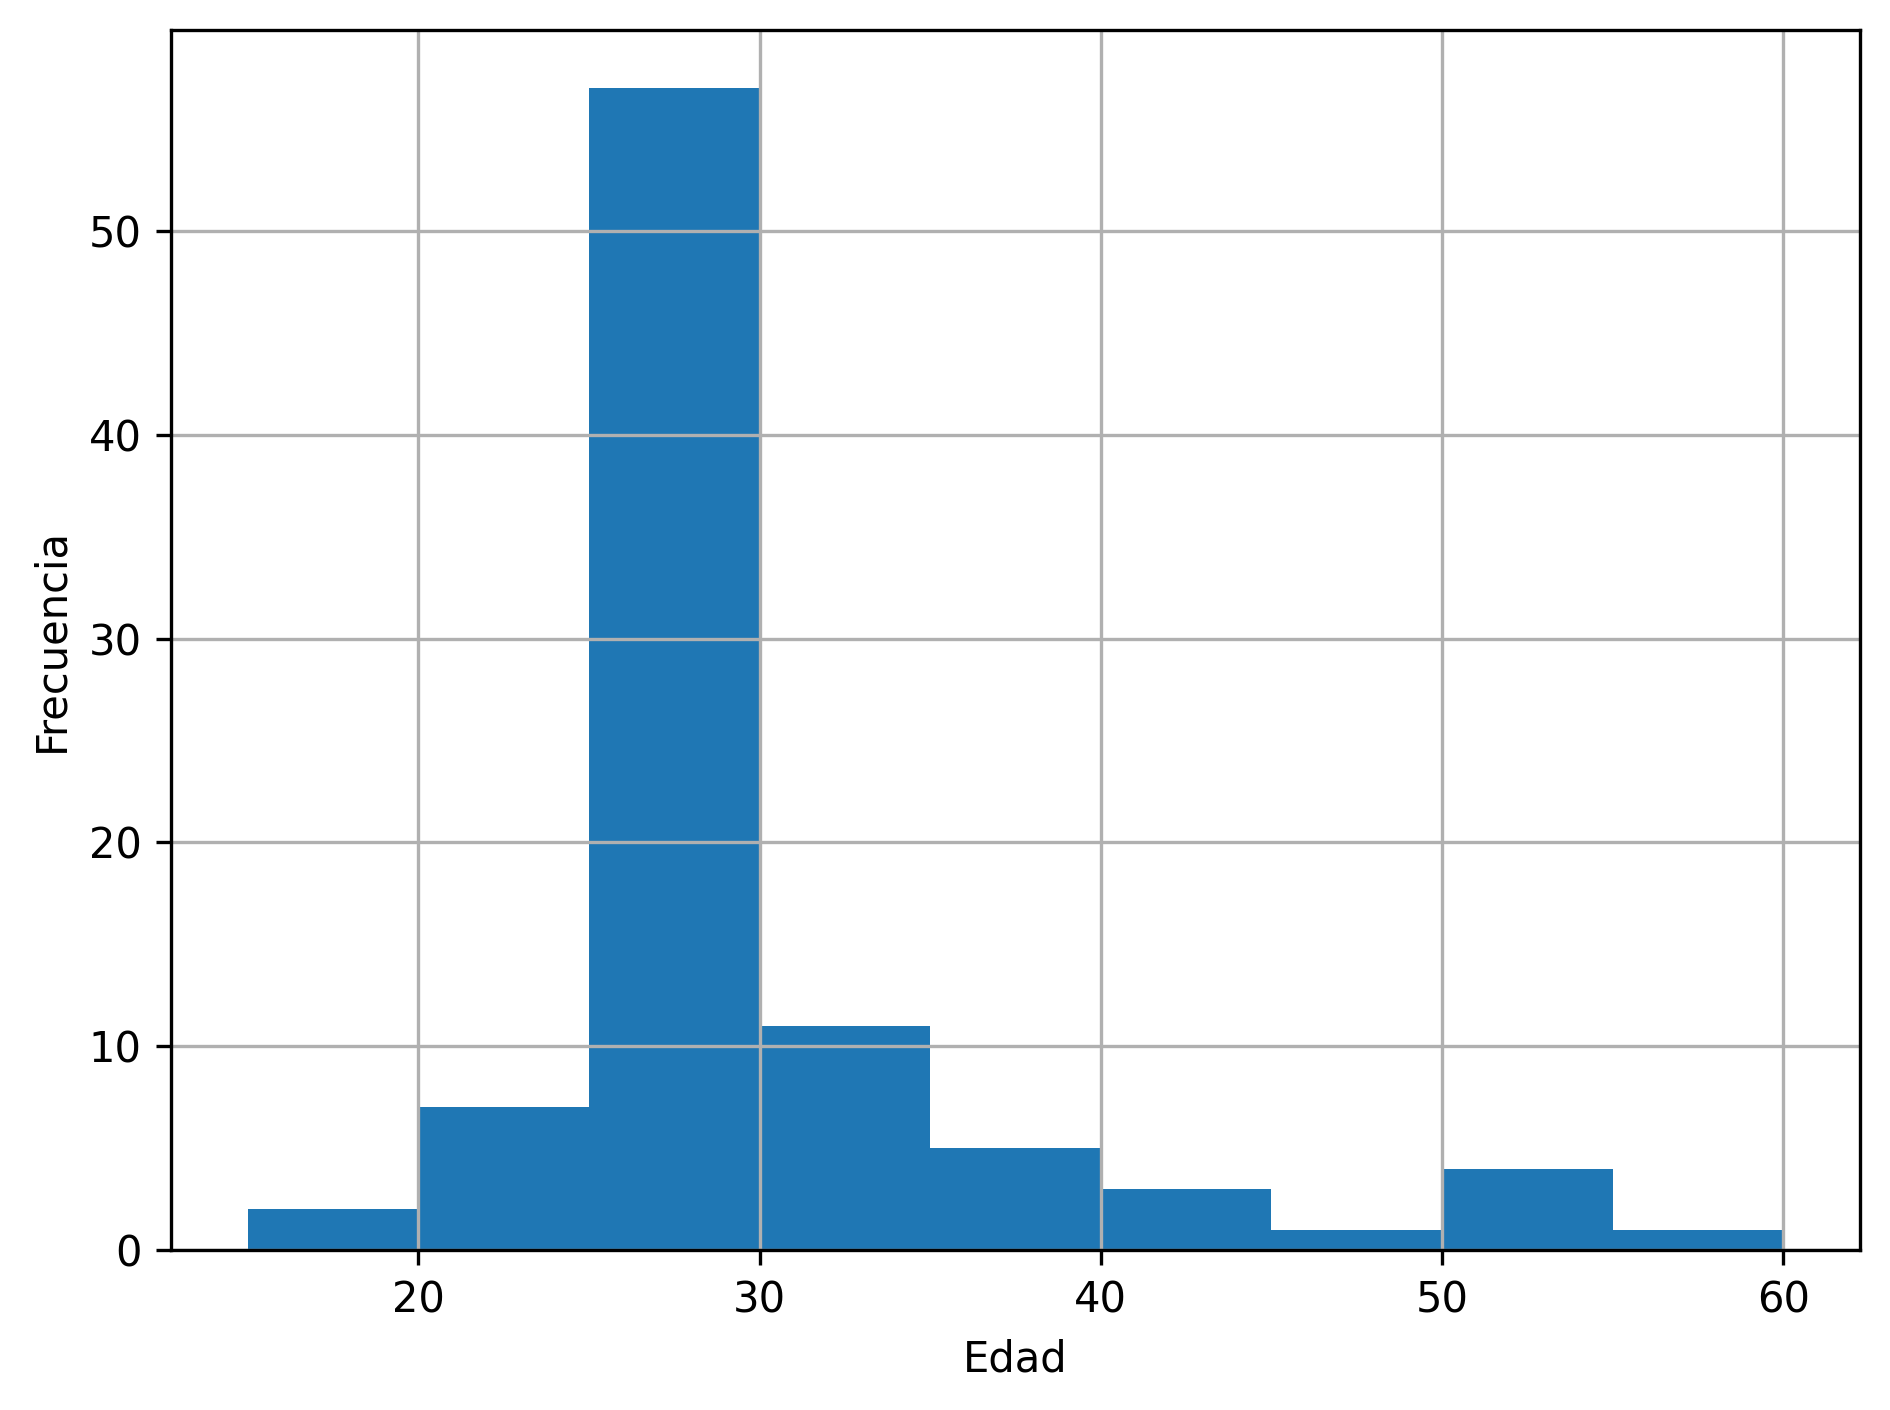

Average age:  29.945652173913043
Standard deviation of age:  8.246696482028335
Median age:  27.0
Minimum age:  18.0
Maximum age:  61.0


In [6]:
# subjective_results["age"] average and histogram
# just count the ages of unique participants, not all the rows
participant_ages = subjective_results.groupby("participant_id")["age"].mean()
participant_ages = participant_ages.dropna()


# set the style of the plot
plt.hist(participant_ages, bins = range(15, 65, 5))
plt.grid(True)
# plt.title('Histogram of ages')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

print("Average age: ", participant_ages.mean())
print("Standard deviation of age: ", participant_ages.std())
print("Median age: ", participant_ages.median())
print("Minimum age: ", participant_ages.min())
print("Maximum age: ", participant_ages.max())

In [22]:
participant_ages.describe()

count    92.000000
mean     29.945652
std       8.246696
min      18.000000
25%      26.000000
50%      27.000000
75%      30.000000
max      61.000000
Name: age, dtype: float64

In [23]:
# gender distribution. Just count the gender of unique participants, not all the rows

gender_distribution = subjective_results.groupby("participant_id")["gender_participant"].first().value_counts()
print(gender_distribution)

gender_participant
M    64
F    25
X     2
P     1
Name: count, dtype: int64


In [24]:

province_distribution = subjective_results.groupby("participant_id")["country"].first().value_counts()
print(province_distribution)

country
AR    90
ES     2
Name: count, dtype: int64


In [25]:
# province distribution. Just count the provinces of unique participants, not all the rows

province_distribution = subjective_results.groupby("participant_id")["province"].first().value_counts()
print(province_distribution)

province
Buenos Aires                       41
Ciudad Autónoma de Buenos Aires    37
Río Negro                           2
Chubut                              2
Tierra del Fuego                    1
Chaco                               1
Neuqu�n                             1
Jujuy                               1
Misiones                            1
Neuquén                             1
La Pampa                            1
Name: count, dtype: int64


In [26]:
# education distribution. Just count the education of unique participants, not all the rows

education_distribution = subjective_results.groupby("participant_id")["education"].first().value_counts()
#print, ordering by education level
print(education_distribution.sort_index())

average_eduaction = subjective_results.groupby("participant_id")["education"].first().mean()
print("Average education: ", average_eduaction)
print("Standard deviation of education: ", subjective_results.groupby("participant_id")["education"].first().std())

education
1    12
2    26
3    21
4    17
5    16
Name: count, dtype: int64
Average education:  2.989130434782609
Standard deviation of education:  1.30505833491269


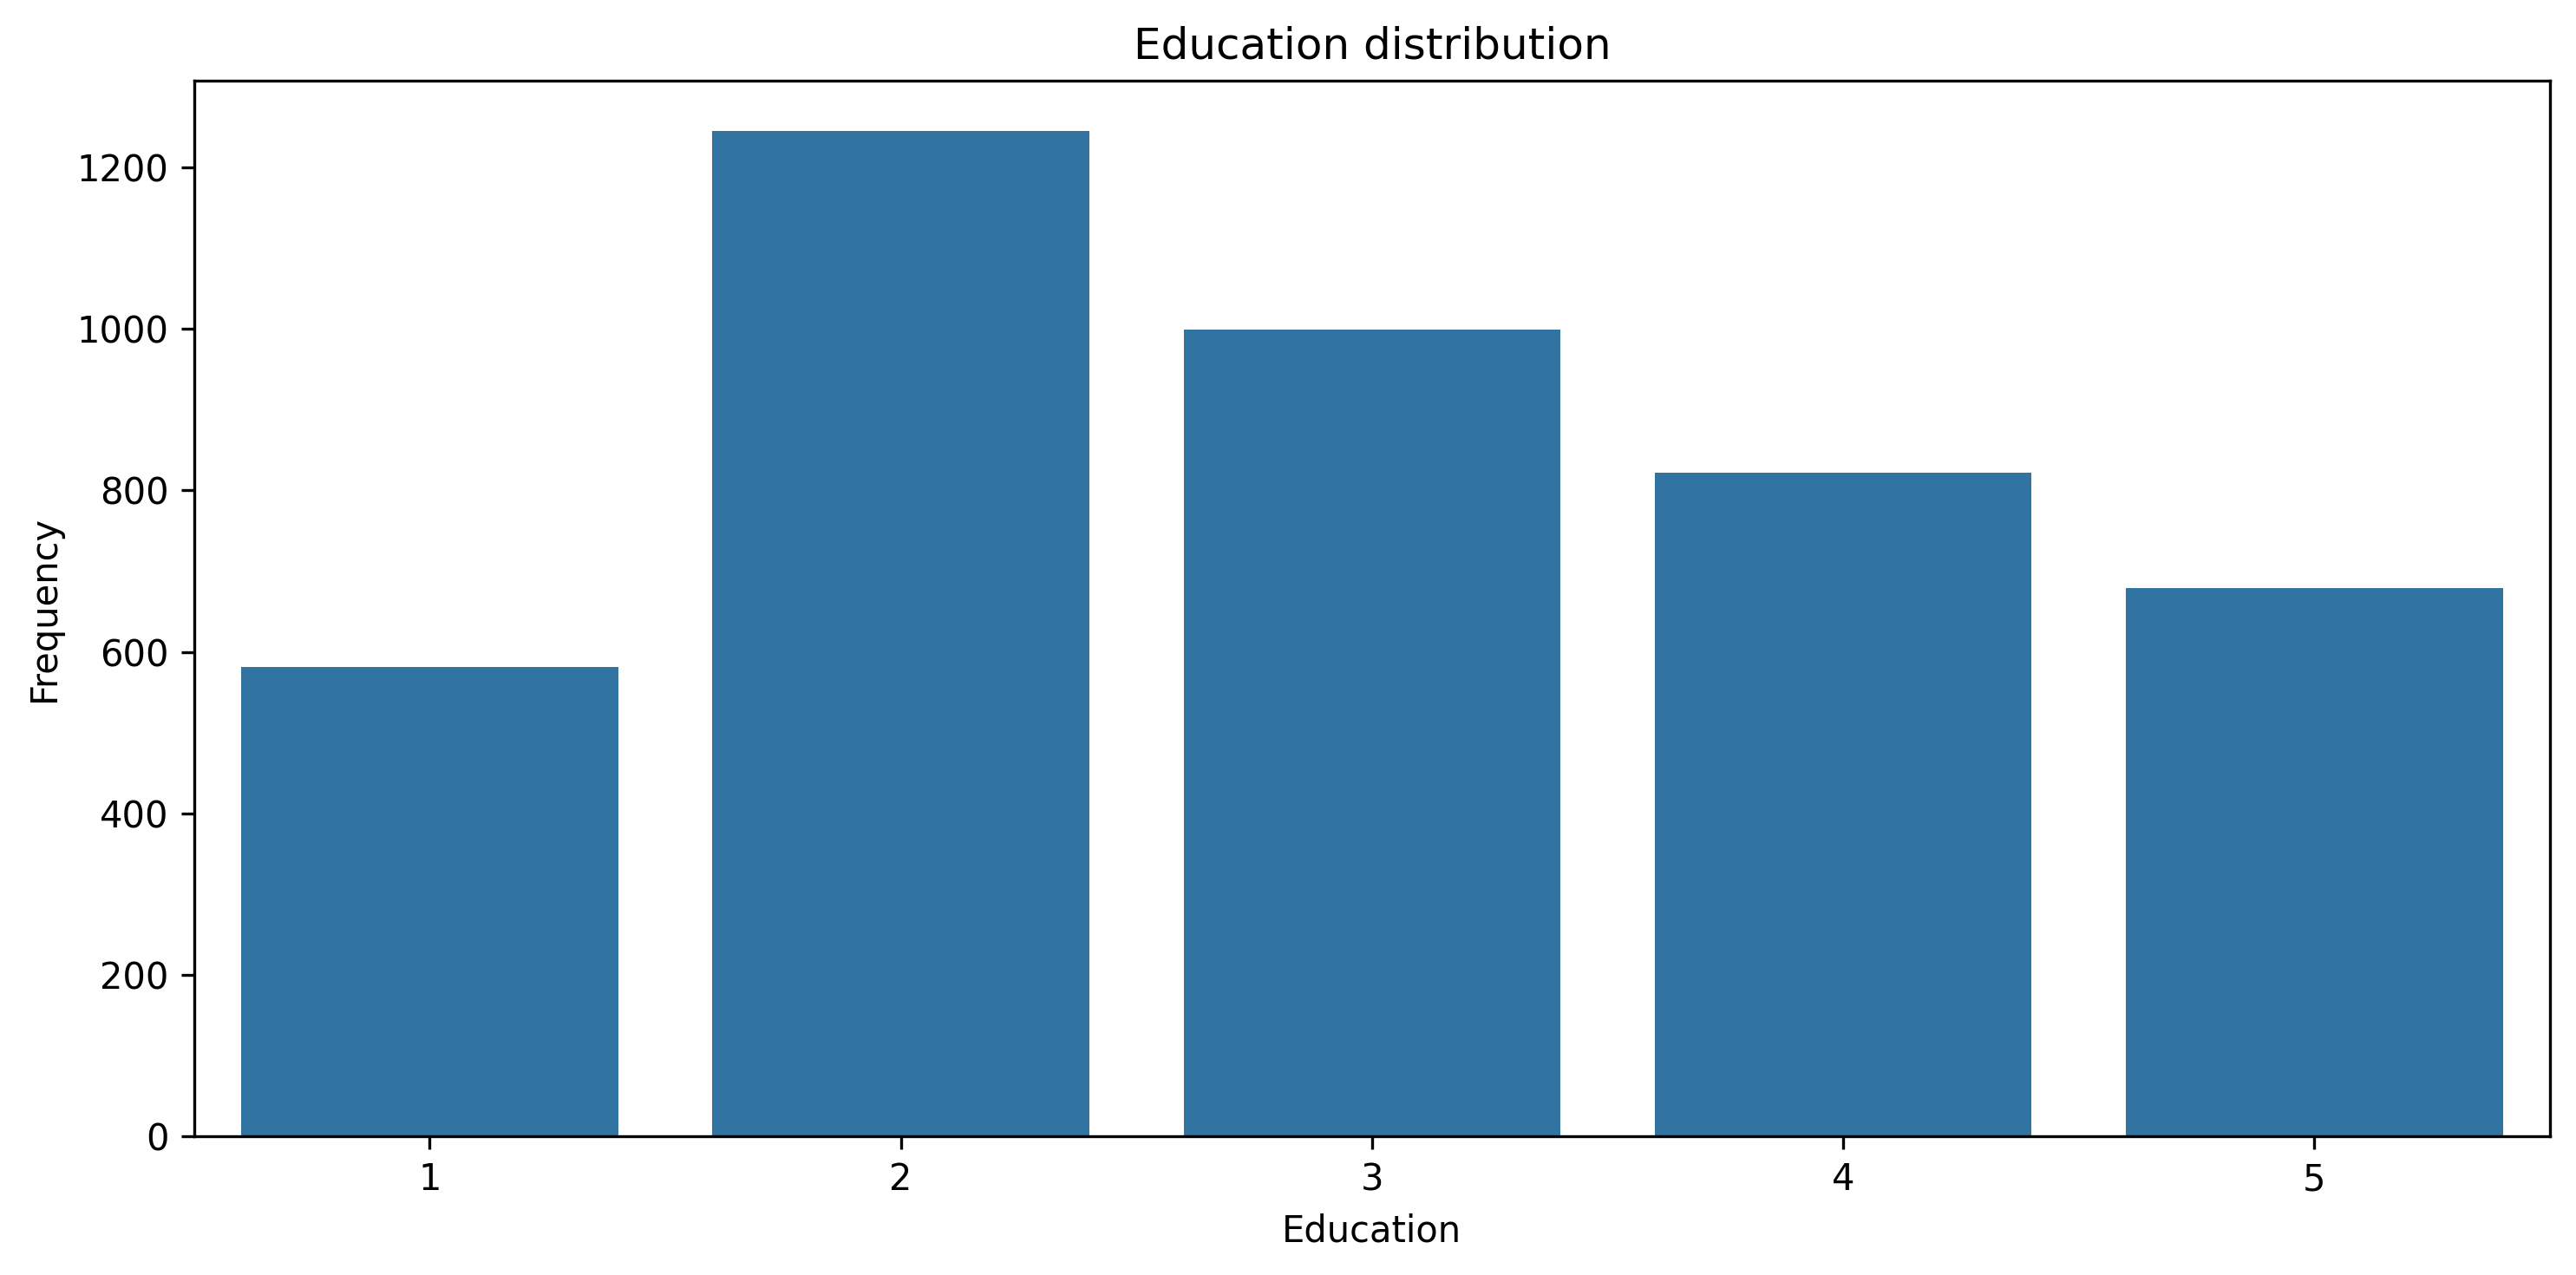

In [7]:
#plot education distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='education', data=subjective_results)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('Education distribution')
plt.show()

### Distribución de los scores de naturalidad del habla:

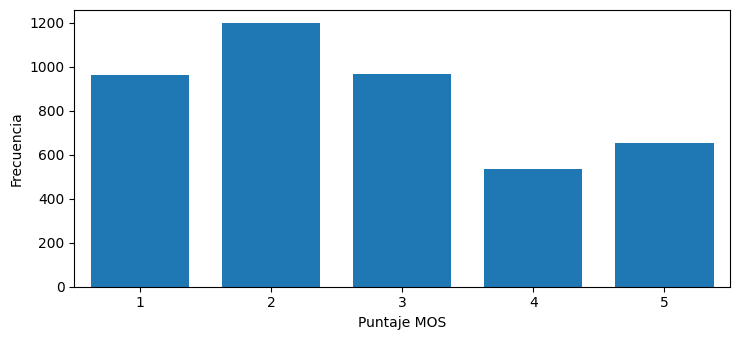

Shapiro-Wilk Test: Statistics=0.885, p=0.000
D’Agostino’s K^2 Test: Statistics=1167.015, p=0.000
Sample does not look Gaussian (reject H0) - Shapiro-Wilk Test
Sample does not look Gaussian (reject H0) - D’Agostino’s K^2 Test


In [28]:
# Extract scores
scores = subjective_results['score']

# Visual Inspection
plt.hist(scores, bins='auto')
# plt.title('Histogram of Scores')
# set x-axis label 1-5
plt.xlabel('Puntaje MOS')
# set y-axis label
plt.ylabel('Frecuencia')
# set x ticks 1-5
plt.xticks(np.arange(1, 6, 1))
# set width of bars
plt.xlim(0.5, 5.5)
# set width of histogram bars to 1.5
plt.bar(np.arange(1, 6, 1), np.histogram(scores, bins=5)[0], width=0.75 )
plt.savefig("puntajes.png", dpi=600)
plt.show()

# Statistical Tests
# Shapiro-Wilk Test
stat, p_shapiro = shapiro(scores)
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p_shapiro))

# D’Agostino’s K^2 Test
stat, p_dagostino = normaltest(scores)
print('D’Agostino’s K^2 Test: Statistics=%.3f, p=%.3f' % (stat, p_dagostino))

# Step 6: Interpretation
alpha = 0.05
if p_shapiro > alpha:
    print('Sample looks Gaussian (fail to reject H0) - Shapiro-Wilk Test')
else:
    print('Sample does not look Gaussian (reject H0) - Shapiro-Wilk Test')

if p_dagostino > alpha:
    print('Sample looks Gaussian (fail to reject H0) - D’Agostino’s K^2 Test')
else:
    print('Sample does not look Gaussian (reject H0) - D’Agostino’s K^2 Test')

In [48]:
# average score
average_score = scores.mean()
average_score

2.704114655570966

In [29]:
# print the amount of each scores 
scores_distribution = subjective_results['score'].value_counts()
scores_distribution

score
2.0    1199
3.0     969
1.0     965
5.0     656
4.0     537
Name: count, dtype: int64

### Agrupación de los estimulos por sistema y calculo de estadisticos descriptivos:

In [3]:
# Group by "stimuli_service" and calculate the statistics
scores_by_system = subjective_results.groupby("stimuli_service")["score"].describe()[["mean", "std", "25%", "50%", "75%"]]

# Print the statistics
print(scores_by_system)

                             mean       std   25%  50%   75%
stimuli_service                                             
Azure-AR-Elena           3.350649  0.996919  3.00  4.0  4.00
Azure-AR-Tomas           2.941176  0.903588  2.00  3.0  4.00
DC-TTS-Catalina          1.890756  1.015055  1.00  2.0  2.50
DC-TTS-Constanza         2.388889  1.166778  2.00  2.0  3.00
DC-TTS-Leo               2.610526  1.222961  2.00  2.0  3.50
DC-TTS-Mauricio          2.818182  1.167748  2.00  3.0  3.50
DC-TTS-Nadia             1.938776  1.110552  1.00  2.0  2.00
DC-TTS-Sebas             1.700000  1.251666  1.00  1.0  2.00
DC_TTS_Mario             2.000000  1.264911  1.00  1.5  2.75
Fastpitch-AR             2.721212  0.997484  2.00  3.0  3.00
Fastpitch-ES             2.551515  0.920008  2.00  2.0  3.00
Fastpitch-ES2            2.769697  0.928047  2.00  3.0  3.00
Fastpitch-Multi-Speaker  1.762376  1.147340  1.00  1.0  2.00
Librivox_ar              4.529851  0.837920  4.00  5.0  5.00
Loquendo-f              

### Puntaje vs grupo de estímulos ordenados por puntaje medio

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and DPI
plt.figure(figsize=(10, 6), dpi=300)


# Save the plot
plt.savefig('high_quality_plot.png', dpi=300)

<Figure size 3000x1800 with 0 Axes>

/tmp/ipykernel_127998/581260601.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette="viridis")


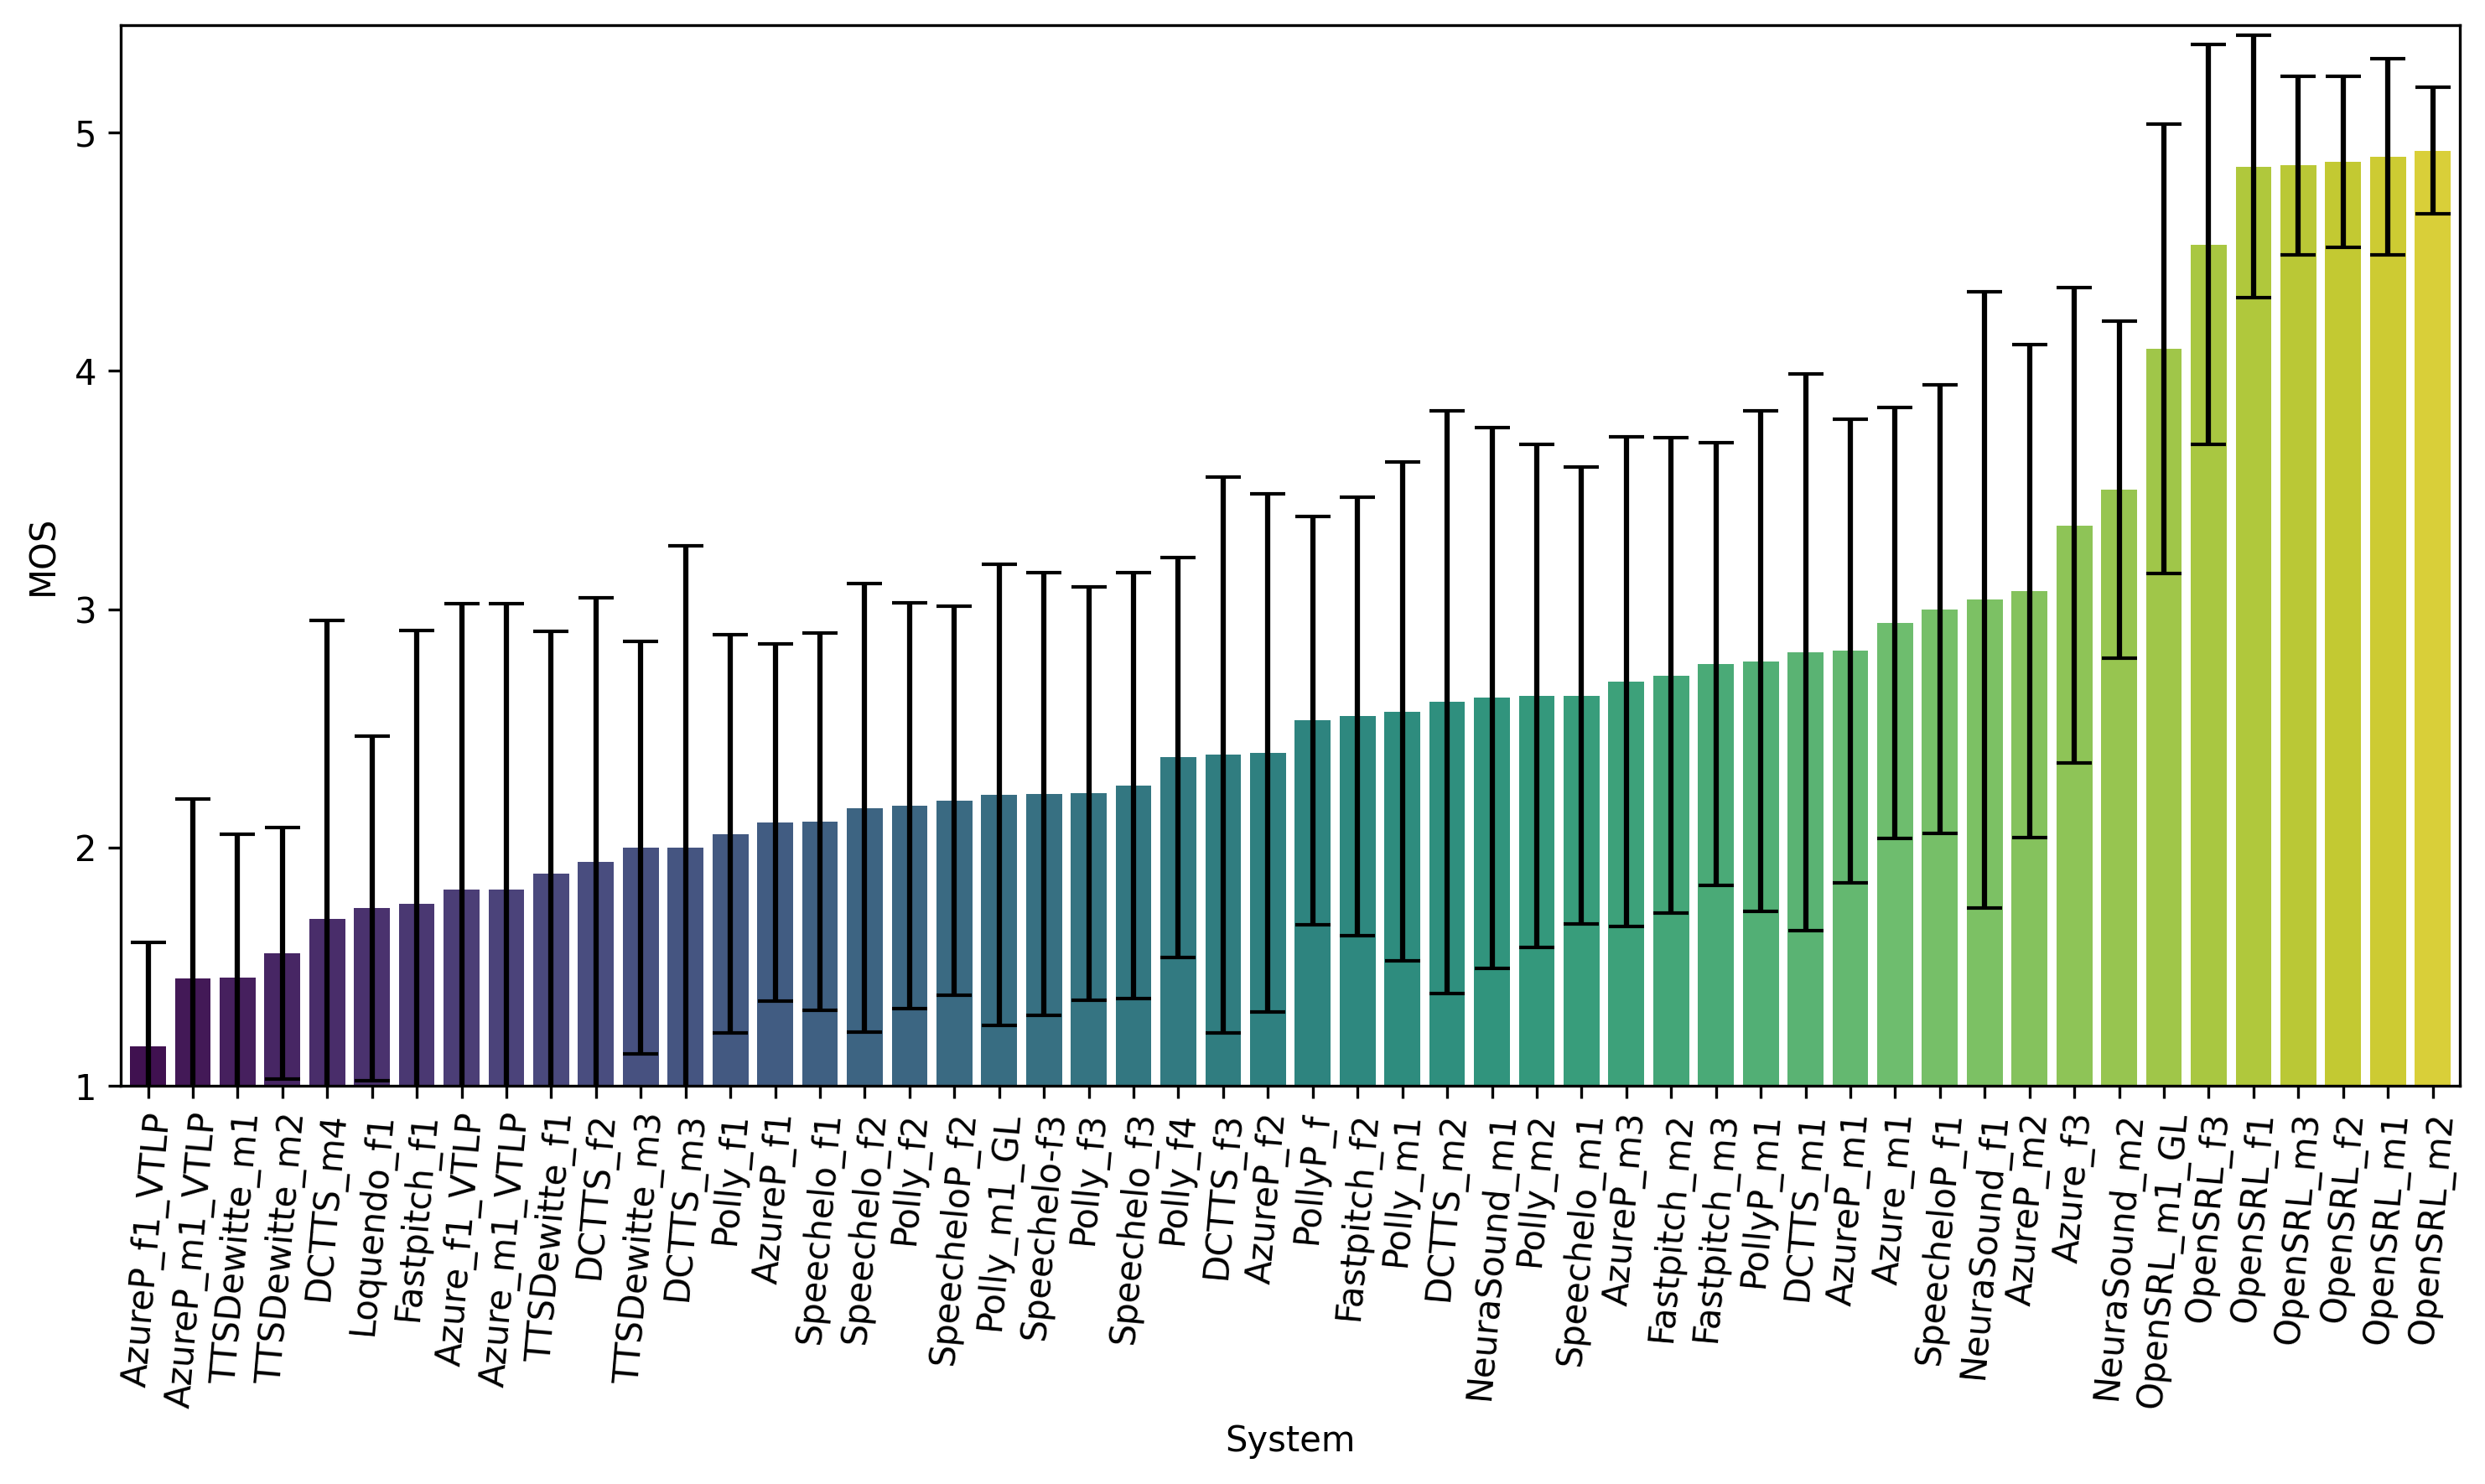

In [38]:
# sort scores_by_system by "mean" in descending order
scores_by_system_sorted = scores_by_system.sort_values(by="mean", ascending=True)

#read from csv
scores_by_system_sorted = pd.read_csv('scores_by_system_sorted.csv')
scores_by_system_sorted.set_index('stimuli_service', inplace=True)

# plot scores_by_system_sorted["mean"] using seaborn

# Define group sizes
group_sizes = [11, 11, 10, 10, 10]  # First 2 groups have 11, last 3 have 10
num_groups = len(group_sizes)

# Define a color palette with five distinct colors
palette = sns.color_palette("viridis", num_groups)

# Assign colors based on group
bar_colors = []
group_start = 0
for group_idx, size in enumerate(group_sizes):
    bar_colors.extend([palette[group_idx]] * size)
    group_start += size

plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette="viridis")
# add standard deviation as error bars
plt.errorbar(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], yerr=scores_by_system_sorted["std"], fmt='none', ecolor='black', capsize=5)
# plt.title("Mean Scores by System")
plt.xlabel("System")
plt.ylabel("MOS")
plt.ylim(1, 5.45)
# set y-axis label 1-5
plt.yticks(np.arange(1, 6, 1))

plt.xticks(
    ticks=range(len(scores_by_system_sorted)), 
    labels=scores_by_system_sorted.index, 
    rotation=85, ha="center")

# Reduce excess space at the top and bottom
plt.xlim(-0.6, len(scores_by_system_sorted) - 0.4)  # Set limits to fit exactly

plt.show() 

/tmp/ipykernel_127998/3657936869.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette=bar_colors)


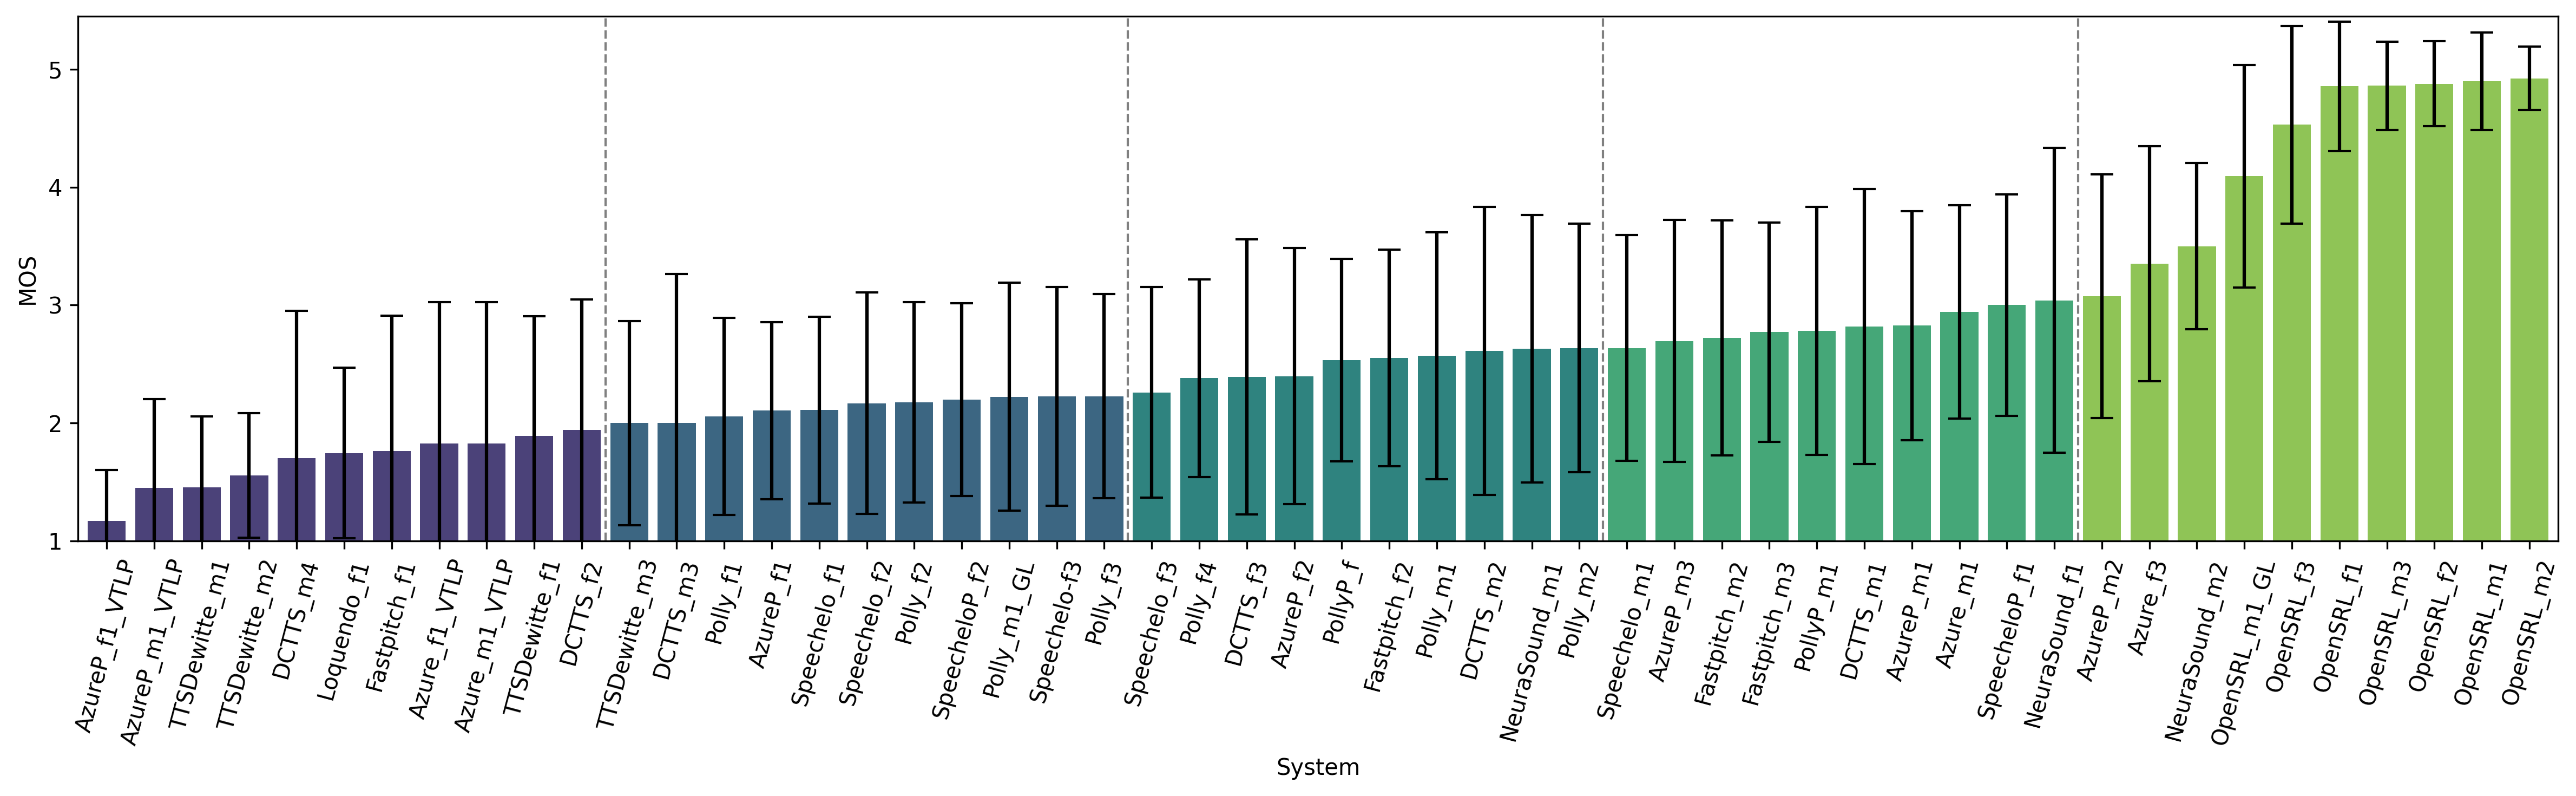

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
scores_by_system_sorted = pd.read_csv('scores_by_system_sorted.csv')
scores_by_system_sorted.set_index('stimuli_service', inplace=True)

# Define group sizes
group_sizes = [11, 11, 10, 10, 10]  # First 2 groups have 11, last 3 have 10
num_groups = len(group_sizes)

# Define a color palette with five distinct colors
palette = sns.color_palette("viridis", num_groups)

# Assign colors based on group
bar_colors = []
group_start = 0
for group_idx, size in enumerate(group_sizes):
    bar_colors.extend([palette[group_idx]] * size)
    group_start += size

# Plot
plt.figure(figsize=(16, 5), dpi=300)
sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette=bar_colors)

# Add standard deviation as error bars
plt.errorbar(x=range(len(scores_by_system_sorted)), 
             y=scores_by_system_sorted["mean"], 
             yerr=scores_by_system_sorted["std"], 
             fmt='none', ecolor='black', capsize=5)

plt.xlabel("System")
plt.ylabel("MOS")
plt.ylim(1, 5.45)
plt.yticks(np.arange(1, 6, 1))

# Rotate x labels
plt.xticks(ticks=range(len(scores_by_system_sorted)), 
           labels=scores_by_system_sorted.index, 
           rotation=75, ha="center")

# Add vertical separators between groups
cumulative_sizes = np.cumsum(group_sizes)
for split in cumulative_sizes[:-1]:  # Ignore last as it would go outside
    plt.axvline(split - 0.5, color='gray', linestyle='--', linewidth=1)

# Reduce excess space
plt.xlim(-0.6, len(scores_by_system_sorted) - 0.4)

plt.show()


/tmp/ipykernel_43830/445524312.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=scores_by_system_sorted.index, x=scores_by_system_sorted["mean"], palette="viridis", orient='h')


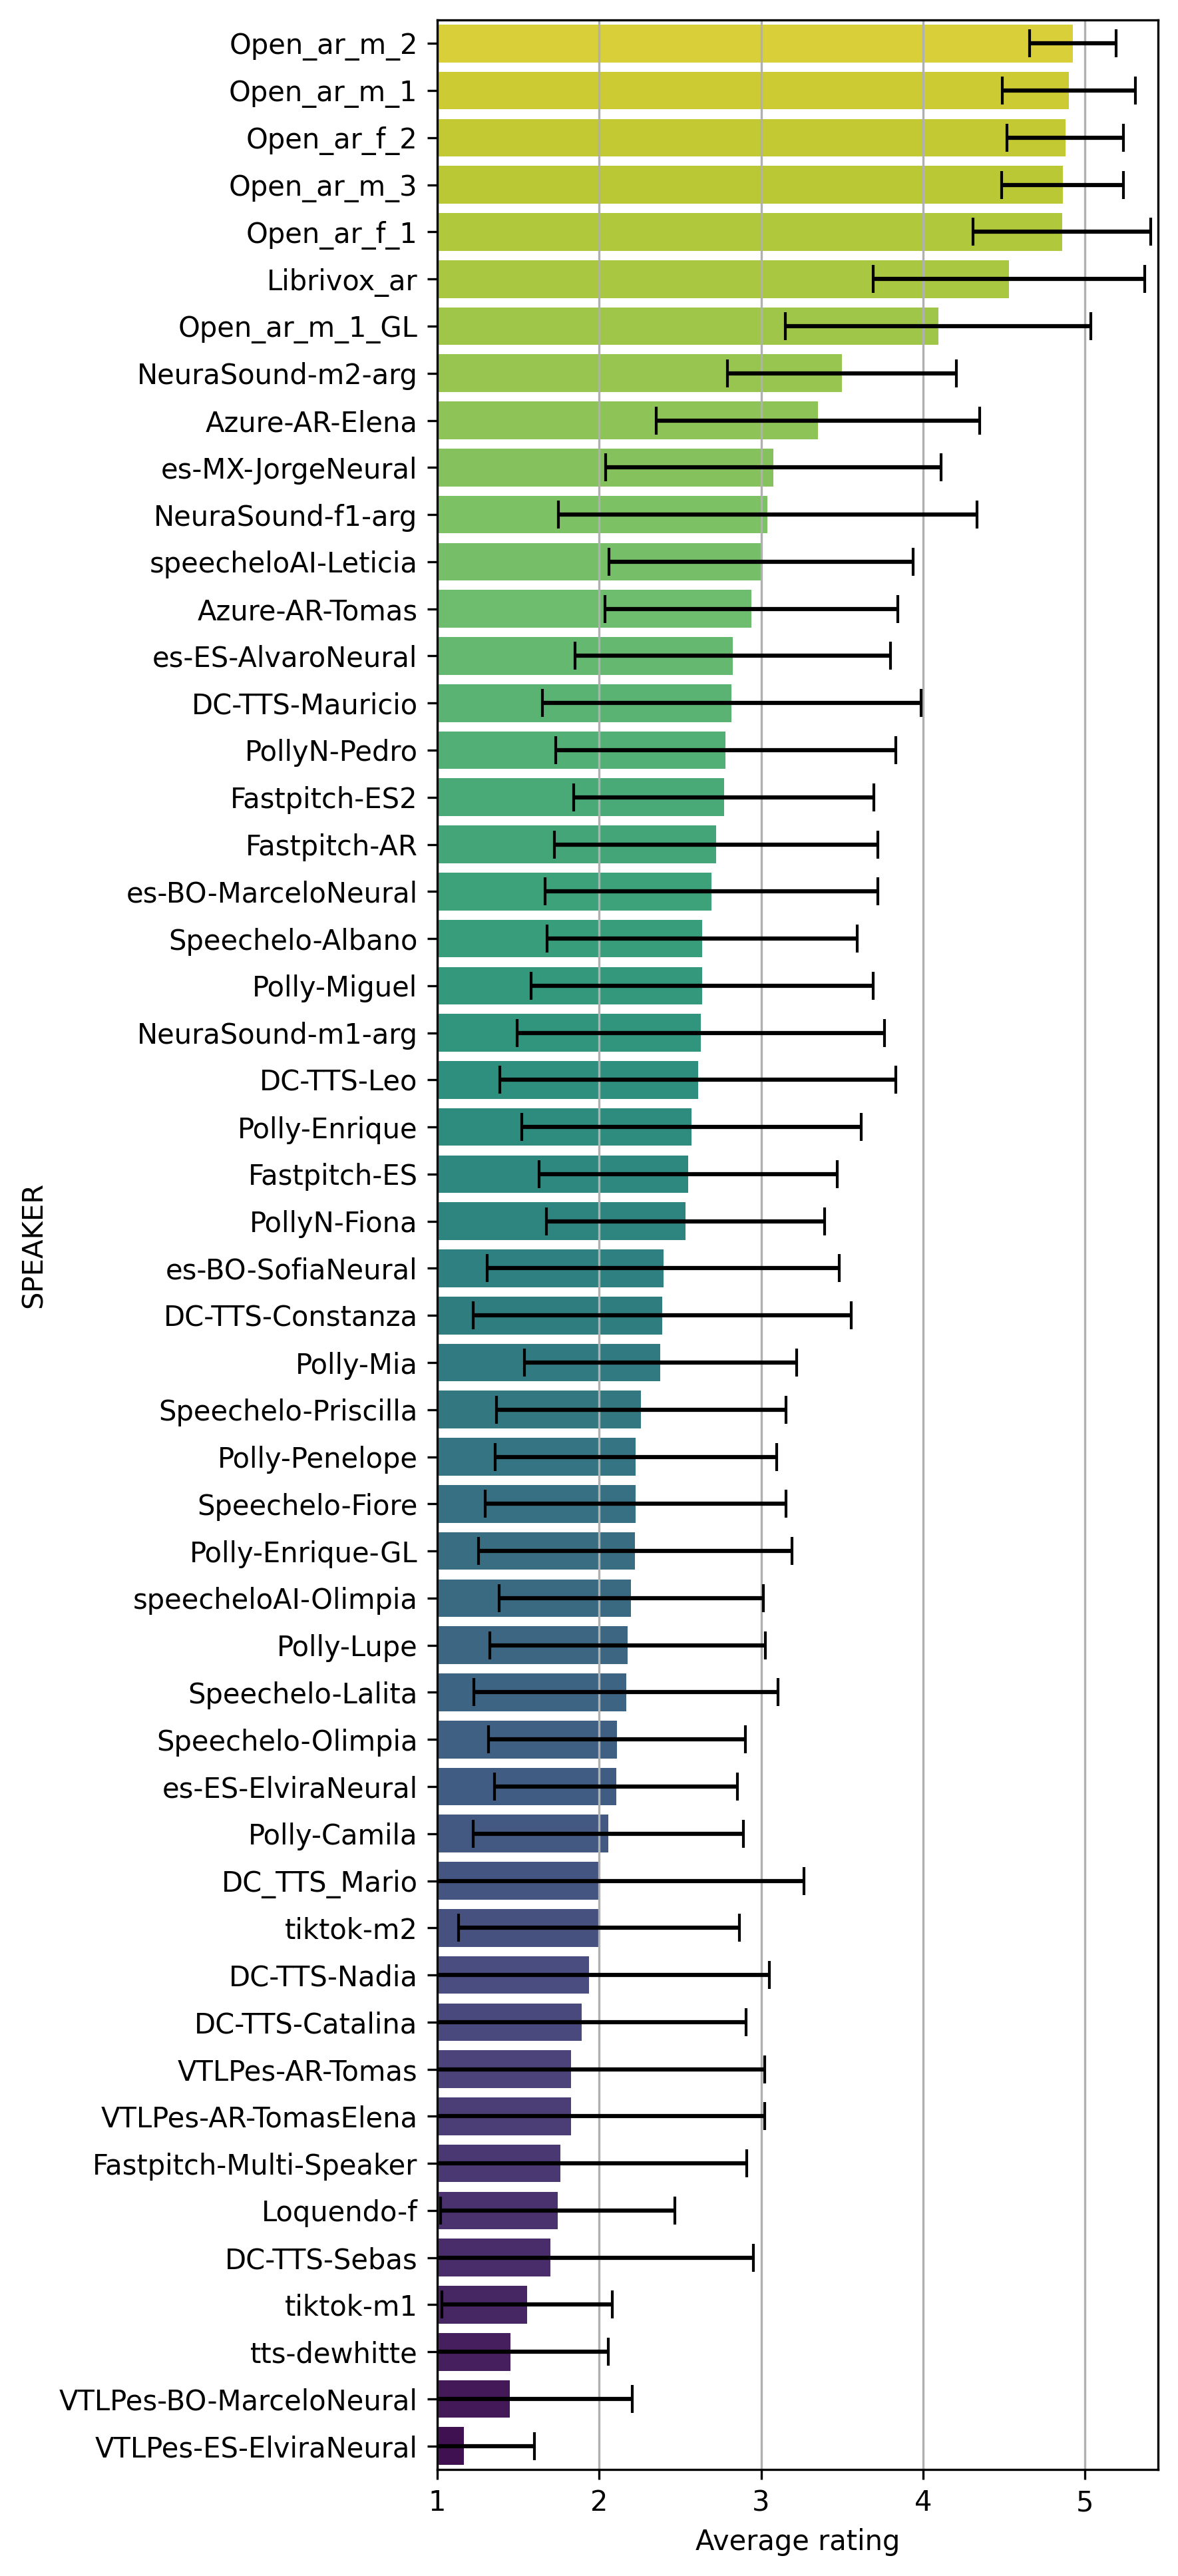

<Figure size 1920x1440 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort scores_by_system by "mean" in ascending order
scores_by_system_sorted = scores_by_system.sort_values(by="mean", ascending=True)

# Set the figure size to be taller than wide
plt.figure(figsize=(6, len(scores_by_system_sorted) * 0.25), dpi=300)  # Adjust height dynamically

# Create a horizontal bar plot
sns.barplot(y=scores_by_system_sorted.index, x=scores_by_system_sorted["mean"], palette="viridis", orient='h')

# Add standard deviation as error bars
plt.errorbar(y=scores_by_system_sorted.index, x=scores_by_system_sorted["mean"], 
             xerr=scores_by_system_sorted["std"], fmt='none', ecolor='black', capsize=5)

# Labels
plt.ylabel("SPEAKER")
plt.xlabel("Average rating")
plt.xlim(1, 5.45)

# add grid to y axis
plt.grid(axis='x')

# Reduce excess space at the top and bottom
plt.ylim(-0.5, len(scores_by_system_sorted) - 0.5)  # Set limits to fit exactly

# Show and save plot
plt.show()
plt.savefig('system_average_score_tight.png', dpi=300, bbox_inches='tight')


In [33]:

# save index and values to csv
scores_by_system_sorted.to_csv('scores_by_system_sorted.csv')

In [34]:
#drop std, 25%, 50%, 75% columns
scores_by_system_sorted = scores_by_system_sorted.drop(columns=["std", "25%", "50%", "75%"])
scores_by_system_sorted

,mean
stimuli_service,
VTLPes-ES-ElviraNeural,1.166667
VTLPes-BO-MarceloNeural,1.449438
tts-dewhitte,1.452830
tiktok-m1,1.555556
DC-TTS-Sebas,1.700000
Loquendo-f,1.744898
Fastpitch-Multi-Speaker,1.762376
VTLPes-AR-TomasElena,1.825397
VTLPes-AR-Tomas,1.825397


# Correlation between score and stimuli_service

## Kruskal-Wallis h-test

In [35]:
import pandas as pd
from scipy.stats import kruskal

# Load the data
file_path = "subjective_results_corrected.csv"
df = pd.read_csv(file_path)

# Convert the 'score' column to float
df['score'] = df['score'].astype(float)

# Group the scores by 'stimuli_service'
groups = df.groupby('stimuli_service')['score'].apply(list)

# Perform the Kruskal-Wallis H test
kruskal_result = kruskal(*groups)

print(kruskal_result)

KruskalResult(statistic=2100.9834457617912, pvalue=0.0)


## post hoc tukey for groups

In [36]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data
df = pd.read_csv('subjective_results_corrected.csv')

# Calculate the mean score for each stimuli_service
mean_scores = df.groupby('stimuli_service')['score'].mean().reset_index()
mean_scores.columns = ['stimuli_service', 'mean_score']

# Create 5 groups based on the mean scores using pd.cut to ensure exactly 5 groups
mean_scores['group'] = pd.cut(mean_scores['mean_score'], bins=5, labels=False)

# Merge the group information back to the original dataframe
df = df.merge(mean_scores[['stimuli_service', 'group']], on='stimuli_service', how='left')

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)

# Print the results
print(tukey.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.6724   0.0 0.5663 0.7785   True
     0      2   1.2247   0.0 1.1037 1.3457   True
     0      3   2.4297   0.0  2.181 2.6784   True
     0      4   3.1497   0.0 3.0133 3.2862   True
     1      2   0.5523   0.0 0.4499 0.6547   True
     1      3   1.7573   0.0 1.5171 1.9975   True
     1      4   2.4773   0.0  2.357 2.5976   True
     2      3    1.205   0.0 0.9578 1.4522   True
     2      4    1.925   0.0 1.7914 2.0587   True
     3      4     0.72   0.0 0.4649 0.9751   True
-------------------------------------------------


## ordinal logistic regression

In [37]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Load the data
df = pd.read_csv('subjective_results_corrected.csv')

# Ensure 'score' is treated as an ordinal variable (integer type)
df['score'] = df['score'].astype(int)

# Calculate the mean score for each stimuli_service
mean_scores = df.groupby('stimuli_service')['score'].mean().reset_index()
mean_scores.columns = ['stimuli_service', 'mean_score']

# Sort stimuli_services by mean_score in ascending order
mean_scores = mean_scores.sort_values(by='mean_score')

# Assign codes based on the sorted order
mean_scores['stimuli_service_code'] = range(len(mean_scores))

# Merge the codes back to the original dataframe
df = df.merge(mean_scores[['stimuli_service', 'stimuli_service_code']], on='stimuli_service', how='left')

# Create an ordinal logistic regression model
model = OrderedModel(df['score'], df[['stimuli_service_code']],
                     distr='logit')

# Fit the model
result = model.fit(method='bfgs')

# Print the summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 1.278265
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:                  score   Log-Likelihood:                -5529.8
Model:                   OrderedModel   AIC:                         1.107e+04
Method:            Maximum Likelihood   BIC:                         1.110e+04
Date:                Tue, 04 Jun 2024                                         
Time:                        23:13:28                                         
No. Observations:                4326                                         
Df Residuals:                    4321                                         
Df Model:                           1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

In [38]:
# Display the mapping of stimuli_service to stimuli_service_code
mapping = df[['stimuli_service', 'stimuli_service_code']].drop_duplicates().sort_values('stimuli_service_code')
print(mapping)

#len of mapping
len(mapping)

              stimuli_service  stimuli_service_code
4120   VTLPes-ES-ElviraNeural                     0
3671  VTLPes-BO-MarceloNeural                     1
900              tts-dewhitte                     2
3300                tiktok-m1                     3
4204             DC-TTS-Sebas                     4
505                Loquendo-f                     5
2699  Fastpitch-Multi-Speaker                     6
3087     VTLPes-AR-TomasElena                     7
3088          VTLPes-AR-Tomas                     8
2901          DC-TTS-Catalina                     9
1336             DC-TTS-Nadia                    10
4317                tiktok-m2                    11
4278             DC_TTS_Mario                    12
98               Polly-Camila                    13
2323       es-ES-ElviraNeural                    14
3850        Speechelo-Olimpia                    15
3760         Speechelo-Lalita                    16
3923               Polly-Lupe                    17
2002      sp

52

# Correlation between other variables and score

## Age

In [39]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Load the data
df = pd.read_csv('subjective_results_corrected.csv')

# Ensure 'score' is treated as a numeric variable
df['score'] = df['score'].astype(float)

# Ensure 'stimuli_service' and 'participant_id' are treated as categorical variables
df['stimuli_service'] = df['stimuli_service'].astype('category')
df['participant_id'] = df['participant_id'].astype('category')

# Fit a linear mixed-effects model
# The formula specifies 'score' as the dependent variable
# 'age' as a fixed effect
# '1' for the intercept
# 'stimuli_service' as groups and 'participant_id' as random effect
model = mixedlm("score ~ age", df, groups=df["stimuli_service"], re_formula="~1")
result = model.fit()

# Print the summary
print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score     
No. Observations: 4326    Method:             REML      
No. Groups:       52      Scale:              0.8416    
Min. group size:  2       Log-Likelihood:     -5882.3966
Max. group size:  202     Converged:          Yes       
Mean group size:  83.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      2.767    0.143 19.330 0.000  2.486  3.048
age           -0.004    0.002 -2.253 0.024 -0.007 -0.000
Group Var      0.910    0.201                           



## Education

In [40]:
# Ensure 'stimuli_service' and 'participant_id' are treated as categorical variables
df['stimuli_service'] = df['stimuli_service'].astype('category')
df['participant_id'] = df['participant_id'].astype('category')

# Fit a linear mixed-effects model
# The formula specifies 'score' as the dependent variable
# 'education' as a fixed effect
# Random intercepts for 'stimuli_service' and 'participant_id'
model = mixedlm("score ~ education", df, groups=df["stimuli_service"], re_formula="~1")
result = model.fit()

# Print the summary
print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score     
No. Observations: 4326    Method:             REML      
No. Groups:       52      Scale:              0.8426    
Min. group size:  2       Log-Likelihood:     -5883.0239
Max. group size:  202     Converged:          Yes       
Mean group size:  83.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      2.662    0.138 19.312 0.000  2.392  2.932
education     -0.003    0.011 -0.258 0.797 -0.024  0.019
Group Var      0.910    0.201                           



## Gender

In [41]:
import pandas as pd

# Load the data
df = pd.read_csv('subjective_results_corrected.csv')

# Eliminate responses from participants with "X" or "P" in gender_participant column
df_filtered = df[~df['gender_participant'].isin(['X', 'P'])]

# Calculate mean and standard deviation of scores
# Group by gender of participants and gender of stimuli
grouped_stats = df_filtered.groupby(['gender_participant', 'gender_stimuli'])['score'].agg(['mean', 'std', 'count']).reset_index()

grouped_stats



,gender_participant,gender_stimuli,mean,std,count
0,F,F,2.490854,1.219401,656
1,F,M,2.994595,1.368142,555
2,M,F,2.517428,1.281605,1664
3,M,M,2.911945,1.421476,1306


# Conclusiones iniciales del análisis exploratorio:

+ la distribución de los scores de naturalidad no sigue una distribución normal 
+ la mayoría de los participantes son de género masculino
+ la mayoría de los participantes tienen entre 25 y 30 años
+ ~fuerte correlación positiva entre el grupo al que pertenece cada audio y su respectiva puntuación


# Regresión logística ordinal (obsleta):

## Supuestos:
1. La variable dependiente está ordenada.
2. Una o más de las variables independientes son continuas, categóricas u ordinales.
3. No hay multicolinealidad.
4. Probabilidades proporcionales.

Los primeros dos supuestos se cumplen sin necesidad de realizar ninguna prueba.

In [42]:
subjective_results = pd.read_csv('subjective_results_corrected.csv')

In [43]:
# # Replace gender_participant values with corresponding numerical values
# # assign one encoding 
# subjective_results['gender_participant'].replace({'F': [1, 0, 0, 0], 'M': [0, 1, 0, 0], 'X': [0, 0, 1, 0], 'P': [0, 0, 0, 1]}, inplace=True)
# subjective_results['gender_stimuli'].replace({'F': [1, 0], 'M': [0, 1]}, inplace=True)
# #replace stimuli_group values with corresponding numerical values A1 = 0, A2 = 1... B1 = 10, B2 = 11... C1 = 20, C2 = 21
# subjective_results['stimuli_group'].replace({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'A7': 6, 'A8': 7, 'A9': 8, 'A10': 9, 'B1': 10, 'B2': 11, 'B3': 12, 'B4': 13, 'B5': 14, 'B6': 15, 'B7': 16, 'B8': 17, 'B9': 18, 'B10': 19, 'C1': 20, 'C2': 21, 'C3': 22, 'C4': 23, 'C5': 24, 'C6': 25, 'C7': 26, 'C8': 27, 'C9': 28, 'C10': 29, 'D1': 30, 'D2': 31, 'D3': 32, 'D4': 33, 'D5': 34, 'D6': 35, 'D7': 36, 'D8': 37, 'D9': 38, 'D10': 39, 'E1': 40, 'E2': 41, 'E3': 42, 'E4': 43, 'E5': 44, 'E6': 45, 'E7': 46, 'E8': 47, 'E9': 48, 'E10': 49}, inplace=True)
# subjective_results['dialect'].replace({'ARG' : [1, 0, 0, 0, 0, 0, 0], 'ES': [0, 1, 0, 0, 0, 0, 0], 'ES-US': [0, 0, 1, 0, 0, 0, 0], 'CAST': [0, 0, 0, 1, 0, 0, 0], 'MEX': [0, 0, 0, 0, 1, 0, 0], 'BO': [0, 0, 0, 0, 0, 1, 0], '-': [0, 0, 0, 0, 0, 0, 1]}, inplace=True)
# subjective_results.head()

In [44]:
# Label Encoding
# Replace gender_participant values with corresponding numerical values
subjective_results['gender_participant'].replace({'F': 0, 'M': 1, 'X': 2, 'P': 3}, inplace=True)
subjective_results['gender_stimuli'].replace({'F': 0, 'M': 1}, inplace=True)
#replace stimuli_group values with corresponding numerical values A1 = 0, A2 = 1... B1 = 10, B2 = 11... C1 = 20, C2 = 21
subjective_results['stimuli_group'].replace({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'A7': 6, 'A8': 7, 'A9': 8, 'A10': 9, 'B1': 10, 'B2': 11, 'B3': 12, 'B4': 13, 'B5': 14, 'B6': 15, 'B7': 16, 'B8': 17, 'B9': 18, 'B10': 19, 'C1': 20, 'C2': 21, 'C3': 22, 'C4': 23, 'C5': 24, 'C6': 25, 'C7': 26, 'C8': 27, 'C9': 28, 'C10': 29, 'D1': 30, 'D2': 31, 'D3': 32, 'D4': 33, 'D5': 34, 'D6': 35, 'D7': 36, 'D8': 37, 'D9': 38, 'D10': 39, 'E1': 40, 'E2': 41, 'E3': 42, 'E4': 43, 'E5': 44, 'E6': 45, 'E7': 46, 'E8': 47, 'E9': 48, 'E10': 49}, inplace=True)
subjective_results['dialect'].replace({'ARG' : 0, 'ES': 1, 'ES-US': 2, 'CAST': 3, 'MEX': 4, 'BO': 5, '-': 6}, inplace=True)
subjective_results.head()



/tmp/ipykernel_51764/3332466701.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  subjective_results['gender_participant'].replace({'F': 0, 'M': 1, 'X': 2, 'P': 3}, inplace=True)
/tmp/ipykernel_51764/3332466701.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjective_results['gender_particip

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,3,AR,Buenos Aires,5,samsung,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,41,Open_ar_f_2,0,0,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,3,AR,Buenos Aires,5,samsung,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,41,Open_ar_f_2,0,0,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,1,AR,Buenos Aires,4,Sony,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,41,Open_ar_f_2,0,0,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,0,AR,Buenos Aires,2,NaN,/home/aleph/tesis/frontend/public/assets/stimu...,4.0,41,Open_ar_f_2,0,0,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,0,AR,Buenos Aires,2,NaN,/home/aleph/tesis/frontend/public/assets/stimu...,4.0,41,Open_ar_f_2,0,0,3.404321,NISQA_TTS_v1


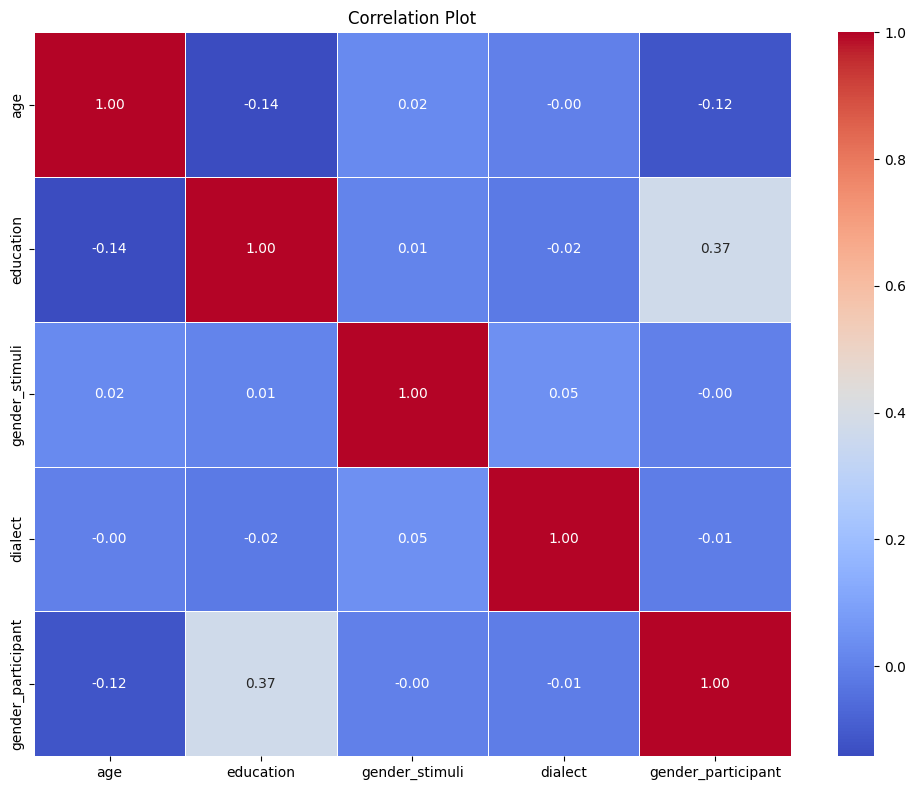

In [45]:
# Select relevant columns
selected_columns = ['age', 'education', 'gender_stimuli','dialect', 'gender_participant']

# Create a subset dataframe with selected columns
subset_script = subjective_results[selected_columns]

# Convert categorical variables to numerical values if needed
# For example, you can use Label Encoding or One-Hot Encoding

# Calculate the correlation matrix
correlation_matrix = subset_script.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Plot')
plt.show()


### Utilizamos VIF para evaluar la multicolinealidad:

In [46]:
# Select relevant columns
selected_columns = ['age', 'gender_participant', 'education', 'stimuli_group', 'gender_stimuli', 'score', 'dialect']

# Create a subset dataframe with selected columns
subset_df = subjective_results[selected_columns]

# Convert categorical variables to numerical values if needed
# For example, you can use Label Encoding or One-Hot Encoding

# Calculate the VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = subset_df.columns
vif_data["VIF"] = [variance_inflation_factor(subset_df.values, i) for i in range(subset_df.shape[1])]

# Display the VIF values
print(vif_data)


NameError: name 'variance_inflation_factor' is not defined

## Evaluar proporcionalidad de probabilidades con la prueba de Brant:

In [ ]:
### COMPLETAR


## Regresión logística ordinal

dependent variable **SCORE** is categorical and ordered

## Hypothesis
Since the outcome variable is categorized and ranked, we can perform an Ordinal Logistic Regression analysis on the dataset. We set the alpha = 0.05 and the hypothesis as follows:

+ H0: there is no statistically significant factors between the variables that influence the Happiness Score
+ H1: there is at least one statistically significant factor between the variables that influence the Happiness Score

In [ ]:
subjective_results = pd.read_csv('subjective_results_corrected.csv')
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1


In [ ]:
subjective_results = pd.get_dummies(subjective_results, columns=['dialect'], prefix='dialect')
subjective_results = pd.get_dummies(subjective_results, columns=["gender_participant"], prefix='gender_participant')
subjective_results = pd.get_dummies(subjective_results, columns=["gender_stimuli"], prefix='gender_stimuli')
subjective_results.head()

,participant_id,age,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,...,dialect_CAST,dialect_ES,dialect_ES-US,dialect_MEX,gender_participant_F,gender_participant_M,gender_participant_P,gender_participant_X,gender_stimuli_F,gender_stimuli_M
0,ymxfxn696we9rp1tnnub3f,26,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,False,True,False,True,False
1,ymxfxn696we9rp1tnnub3f,26,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,False,True,False,True,False
2,9fig36z1cml41m265ckifw,25,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,True,False,False,True,False
3,vj735xlt2yj805wyn5rimq,59,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,True,False,False,False,True,False
4,vj735xlt2yj805wyn5rimq,59,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,True,False,False,False,True,False
